In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# ----- Load -----
DATA_PATH = r"KOA_Dataset_optionA.csv"
TARGET = "KOA"  

df = pd.read_csv(DATA_PATH)

# drop useless columns (optional but recommended)
df = df.drop(columns=["Timestamp", "Column 1", "Patient Identification Number"], errors="ignore")

# Make sure target exists
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns: {df.columns.tolist()}")

X = df.drop(columns=[TARGET], errors="ignore")
y = df[TARGET]

# If KOA is text labels, encode automatically
if y.dtype == "object":
    y = y.astype("category").cat.codes
else:
    y = y.astype(int)

# ----- Columns -----
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# ----- Preprocess -----
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))]), cat_cols),
    ],
    remainder="drop"
)

# ----- Split -----
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

# ----- Model -----
xgb = XGBClassifier(
    n_estimators=80,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=20,
    gamma=1.0,
    reg_alpha=30,
    reg_lambda=30,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([("preprocess", preprocess), ("model", xgb)])
pipe.fit(X_train, y_train)

print("XGBoost Accuracy")
print("Train:", accuracy_score(y_train, pipe.predict(X_train)))
print("Val  :", accuracy_score(y_val, pipe.predict(X_val)))
print("Test :", accuracy_score(y_test, pipe.predict(X_test)))


XGBoost Accuracy
Train: 0.85625
Val  : 0.91875
Test : 0.875


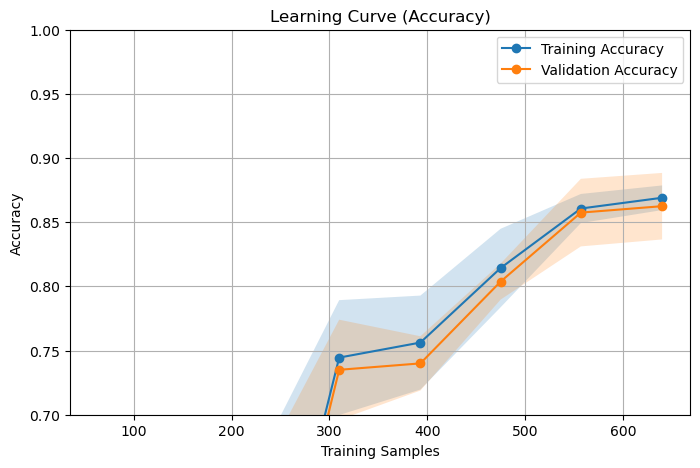

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve

# Use Train+Val set for learning curve
X_lc = X_trainval
y_lc = y_trainval

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 8)

sizes_abs, train_scores, val_scores = learning_curve(
    estimator=pipe,          # <- your trained pipeline (xgb / gb / lr / knn)
    X=X_lc,
    y=y_lc,
    train_sizes=train_sizes,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(sizes_abs, train_mean, marker="o", label="Training Accuracy")
plt.plot(sizes_abs, val_mean, marker="o", label="Validation Accuracy")

plt.fill_between(sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Accuracy)")
plt.ylim(0.70, 1.0)
plt.grid(True)
plt.legend()
plt.show()
